In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44925")
client

<Client: 'tcp://127.0.0.1:44925' processes=8 threads=32, memory=125.89 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:44925' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [6]:
years = np.arange(1967,1968,dtype=int)
# ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
# dd = 0  # 
# yystart = 0
# ntimes[yystart,:]

In [7]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

dCs = 1e-5
Cs = xr.open_dataset(op.join(savedir,"Max-sound-speed_1967-01-01.nc")).Cs

ntheta = 36
xo = 50e3
# s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
#                  coords={'scale':np.arange(.5,10.5,.5)}
#                 )

$$\eta_K = \frac{1}{C_\Psi}\int_{\kappa>k} \mathcal{R}\left[ \overline{\tilde{q'}^*\widetilde{\boldsymbol{v}\cdot\nabla q'}} + \widetilde{\overline{q'\boldsymbol{v}'}}^*\cdot\widetilde{\nabla\overline{q}} + \tilde{\overline{q}}^*\widetilde{\nabla\cdot\overline{\boldsymbol{v}'q'}} \right] x_0^2 \kappa\, d\kappa$$

# Wavelet
## Native grid

In [8]:
nmembs = np.arange(100,148)
xchunk = 100
ychunk = 100
reg = 0

ng = 2

iiter = 1419120
dsgrd = open_mdsdataset(op.join(ddir,'memb%03d/run%4d/ocn/' 
                                        % (100,years[0])), 
                                grid_dir=gdir,
                                prefix=['snap_diagOcn'], delta_t=2e2,
                                iters=iiter, 
                               ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                     YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                     XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                     XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                    ).isel(time=0).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1,
                                                          'YC':-1,'YG':-1,'XG':-1,'XC':-1})
            
dsq = xr.open_zarr(op.join(savedir,'SnapErtelPV/%2dmembers/15N-50N_%010d.zarr'
                                   % (len(nmembs),iiter))
                          ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                               ).chunk({'Z':1,'YC':-1,'XC':-1})
            
# dsb = xr.open_zarr(op.join(savedir,'Snaps_EnsMean_%010d.zarr' % itime)
#                               ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
#                                     YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
#                                     XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
#                                     XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
#                                    ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1,
#                                             'YC':-1,'YG':-1,'XG':-1,'XC':-1})
dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                           YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                           XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                           XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                          ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

for nmemb in nmembs:
    if nmemb == 100:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                             % (nmemb)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn'], delta_t=2e2,
                                     iters=iiter, 
                                    ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                          YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                          XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                          XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                         ).isel(time=0)
    else:
        ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                            % (nmemb)), 
                                                    grid_dir=gdir,
                                                    prefix=['snap_diagOcn'], delta_t=2e2,
                                                    iters=iiter, 
                                                   ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                                         YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                                         XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                                         XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                                        ).isel(time=0)
                               ], dim='nmemb')

ds.coords['nmemb'] = ('nmemb',nmembs)

        
grid = Grid(ds, periodic=[])
xA = (dsgrd.dyG * dsgrd.drF).reset_coords(drop=True)
yA = (dsgrd.dxG * dsgrd.drF).reset_coords(drop=True)

In [9]:
v = ds.VVEL.where(ds.maskS!=0.)
u = ds.UVEL.where(ds.maskW!=0.)
w = ds.WVEL
up = (u - dsb.UVEL).where(ds.maskW!=0.)
vp = (v - dsb.VVEL).where(ds.maskS!=0.)
wp = (w - dsb.WVEL)
theta = ds.THETA.where(ds.maskC!=0.)
salt = ds.SALT.where(ds.maskC!=0.)

PVb = (dsq.bEPVh + dsq.bEPVv)
PVp = (dsq.pEPVh + dsq.pEPVv)
PV = PVb + PVp

# PVb_y = grid.interp(grid.diff(PVb,'Y',boundary='extend') / ds.dyC,'Y',boundary='extend')
# PVb_x = grid.interp(grid.diff(PVb,'X',boundary='extend') / ds.dxC,'X',boundary='extend')
# PVb_z = grid.interp(-grid.diff(PVb,'Z',boundary='extend') 
#                     / ds.drC.data[:-1,np.newaxis,np.newaxis],
#                     'Z',boundary='extend')
        
utTrans = up.reset_coords(drop=True) * xA * dsgrd.hFacW
vtTrans = vp.reset_coords(drop=True) * yA * dsgrd.hFacS
rtTrans = (wp*dsgrd.rA).reset_coords(drop=True)
Auq = (utTrans
       * grid.interp(PVp,'X',boundary='extend')
      )
Avq = (vtTrans
       * grid.interp(PVp,'Y',boundary='extend')
      )
Awq = (rtTrans
       * grid.interp(PVp,'Z',boundary='extend')
      )

Aq = ((grid.diff(Auq,'X',boundary='extend')
       + grid.diff(Avq,'Y',boundary='extend')
       - grid.diff(Awq,'Z',boundary='extend')
      ) / dsgrd.drF/dsgrd.rA/dsgrd.hFacC
     ).isel(Z=[14,18,24],YC=slice(ng,-ng),XC=slice(ng,-ng)).compute()
        
UtTrans = u.reset_coords(drop=True) * xA * dsgrd.hFacW
VtTrans = v.reset_coords(drop=True) * yA * dsgrd.hFacS
RtTrans = (w*dsgrd.rA).reset_coords(drop=True)
AUQ = (UtTrans
       * grid.interp(PV,'X',boundary='extend')
      )
AVQ = (VtTrans
       * grid.interp(PV,'Y',boundary='extend')
      )
AWQ = (RtTrans
       * grid.interp(PV,'Z',boundary='extend')
      )

AQ = ((grid.diff(AUQ,'X',boundary='extend')
       + grid.diff(AVQ,'Y',boundary='extend')
       - grid.diff(AWQ,'Z',boundary='extend')
      ) / dsgrd.drF/dsgrd.rA/dsgrd.hFacC
     ).isel(Z=[14,18,24],YC=slice(ng,-ng),XC=slice(ng,-ng))
AQp = (AQ - AQ.mean('nmemb',skipna=True)).compute()
            
# upPVp = (grid.interp(up,'X',boundary='extend')*PVp
#         ).isel(Z=[14,18,24],YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True).compute()
# vpPVp = (grid.interp(vp,'Y',boundary='extend')*PVp
#         ).isel(Z=[14,18,24],YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True).compute()
# wpPVp = (grid.interp(wp,'Z',boundary='extend')*PVp
#         ).isel(Z=[14,18,24],YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True).compute()
        
            
print(Aq, AQp)
#             Aqp.isel(nmemb=0,Z=0).plot()
#             plt.show()

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(


<xarray.DataArray (nmemb: 48, Z: 3, YC: 120, XC: 116)>
array([[[[-1.92155120e-16, -3.53789963e-16, -5.18623671e-16, ...,
          -1.31345097e-16, -5.97684475e-17,  2.51140527e-17],
         [-1.99822662e-16, -3.27328182e-16, -4.67074348e-16, ...,
          -1.76275417e-16, -1.19196567e-16, -5.17783258e-17],
         [-2.14925187e-16, -2.52453936e-16, -3.41746987e-16, ...,
          -2.11470518e-16, -1.68672005e-16, -1.18309170e-16],
         ...,
         [            nan,             nan,             nan, ...,
           3.08789288e-17,  4.43498308e-17,  4.89187385e-17],
         [            nan,             nan,             nan, ...,
           5.52748730e-17,  6.07185557e-17,  6.50904127e-17],
         [            nan,             nan,             nan, ...,
           6.22862467e-17,  5.20156899e-17,  4.86315931e-17]],

        [[-1.65895254e-18,  2.09993288e-17,  4.00414781e-17, ...,
          -7.88201510e-18, -5.53475376e-18,  1.92077490e-18],
         [ 6.10879645e-19,  2.661

In [10]:
xT = grid.cumsum(dsgrd.dxC,'X',boundary='extend'
                ).isel(YC=slice(ng,-ng),XC=slice(ng,-ng))
yT = grid.cumsum(dsgrd.dyC,'Y',boundary='extend'
                ).isel(YC=slice(ng,-ng),XC=slice(ng,-ng))
ny, nx = xT.shape
xT = xT - xT.isel(XC=nx//2)
xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
yT = (yT - yT.isel(YC=0)).values.flatten()
dx = dsgrd.dxC.isel(YC=slice(ng,-ng),XG=slice(ng,-ng)).min().values
dy = dsgrd.dyC.isel(YG=slice(ng,-ng),XC=slice(ng,-ng)).min().values
N = ds.THETA.isel(nmemb=0,Z=0).shape
ss = xr.open_zarr('/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_1967-01-01.zarr' % reg).scale/xo
# ss = xr.DataArray(np.linspace(2*np.maximum(dx,dy),10*xo,30)/xo, dims=['scale'], 
#                   coords={'scale':np.linspace(2*dx,10*xo,30)/xo}
#                  )
N = AQ.isel(Z=0).shape

In [11]:
PVterp = xr.DataArray(np.ones_like(AQp), dims=AQp.dims,
                        coords={'nmemb':nmembs,'Z':AQp.Z,
                                'YC':np.arange(0,N[-2]*dy,dy),
                                'XC':np.arange(0,N[-1]*dx,dx)}
                     )
PVterb = xr.DataArray(np.ones_like(Aq.isel(nmemb=0)), dims=Aq.isel(nmemb=0).dims,
                      coords={'Z':Aq.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
# PV_xterb = xr.DataArray(np.ones_like(AQ.isel(nmemb=0)), dims=AQ.isel(nmemb=0).dims,
#                         coords={'Z':AQ.Z,
#                                 'YC':np.arange(0,N[-2]*dy,dy),
#                                 'XC':np.arange(0,N[-1]*dx,dx)}
#                         )
# PV_yterb = xr.DataArray(np.ones_like(AQ.isel(nmemb=0)), dims=AQ.isel(nmemb=0).dims,
#                         coords={'Z':AQ.Z,
#                                 'YC':np.arange(0,N[-2]*dy,dy),
#                                 'XC':np.arange(0,N[-1]*dx,dx)}
#                         )
# PV_zterb = xr.DataArray(np.ones_like(AQ.isel(nmemb=0)), dims=AQ.isel(nmemb=0).dims,
#                         coords={'Z':AQ.Z,
#                                 'YC':np.arange(0,N[-2]*dy,dy),
#                                 'XC':np.arange(0,N[-1]*dx,dx)}
#                         )
Aqterp = xr.DataArray(np.ones_like(Aq), dims=Aq.dims,
                      coords={'nmemb':nmembs,'Z':Aq.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
AQterp = xr.DataArray(np.ones_like(AQp), dims=AQp.dims,
                      coords={'nmemb':nmembs,'Z':AQp.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
# upPterp = xr.DataArray(np.ones_like(Aq), dims=Aq.dims,
#                         coords={'nmemb':nmembs,'Z':Aq.Z,
#                                 'YC':np.arange(0,N[-2]*dy,dy),
#                                 'XC':np.arange(0,N[-1]*dx,dx)}
#                         )
# vpPterp = xr.DataArray(np.ones_like(Aq), dims=Aq.dims,
#                         coords={'nmemb':nmembs,'Z':Aq.Z,
#                                 'YC':np.arange(0,N[-2]*dy,dy),
#                                 'XC':np.arange(0,N[-1]*dx,dx)}
#                         )
# wpPterp = xr.DataArray(np.ones_like(Aq), dims=Aq.dims,
#                         coords={'nmemb':nmembs,'Z':Aq.Z,
#                                 'YC':np.arange(0,N[-2]*dy,dy),
#                                 'XC':np.arange(0,N[-1]*dx,dx)}
#                         )
   
xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]

In [12]:
rAterp = griddata((xT, yT), (dsgrd.rA).isel(YC=slice(ng,-ng),XC=slice(ng,-ng)).values.flatten(),
                  (xxx, yyy) 
                 ).T

In [13]:
for iz in range(len(AQ.Z)):
    for nn in range(len(nmembs)):
                    
        PVterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (PVp.isel(Z=[14,18,24],YC=slice(ng,-ng),XC=slice(ng,-ng))
                                                    * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                   )
                                                 ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        # upPterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
        #                                           (upPVp*dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
        #                                                               )
        #                                           ).isel(nmemb=nn,Z=iz).values.flatten(),
        #                                           (xxx, yyy) 
        #                                          ).T 
        # vpPterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
        #                                           (vpPVp*dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
        #                                                               )
        #                                           ).isel(nmemb=nn,Z=iz).values.flatten(),
        #                                           (xxx, yyy) 
        #                                          ).T 
        # wpPterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
        #                                           (wpPVp*dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
        #                                                              )
        #                                           ).isel(nmemb=nn,Z=iz).values.flatten(),
        #                                           (xxx, yyy) 
        #                                          ).T 
        AQterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (AQp*dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                  )
                                                 ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        Aqterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                        (Aq*dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                         )
                                        ).isel(nmemb=nn,Z=iz).values.flatten(),
                                        (xxx, yyy) 
                                       ).T 
    PVterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                    (PVb.isel(Z=[14,18,24],YC=slice(ng,-ng),XC=slice(ng,-ng))
                                     * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                    )
                                    ).isel(Z=iz).values.flatten(),
                                    (xxx, yyy) 
                                    ).T   
    # PV_xterb.isel(Z=iz)[:] = griddata((xT, yT), 
    #                                   (PVb_x.isel(Z=[14,18,24],YC=slice(ng,-ng),XC=slice(ng,-ng))
    #                                    * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
    #                                                   )
    #                                   ).isel(Z=iz).values.flatten(),
    #                                   (xxx, yyy) 
    #                                  ).T 
    # PV_yterb.isel(Z=iz)[:] = griddata((xT, yT), 
    #                                   (PVb_y.isel(Z=[14,18,24],YC=slice(ng,-ng),XC=slice(ng,-ng))
    #                                    * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
    #                                                   )
    #                                   ).isel(Z=iz).values.flatten(),
    #                                   (xxx, yyy) 
    #                                  ).T 
    # PV_zterb.isel(Z=iz)[:] = griddata((xT, yT), 
    #                                   (PVb_z.isel(Z=[14,18,24],YC=slice(ng,-ng),XC=slice(ng,-ng))
    #                                    * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
    #                                                   )
    #                                   ).isel(Z=iz).values.flatten(),
    #                                   (xxx, yyy) 
    #                                  ).T 
        
PVterp   = PVterp / rAterp
Aqterp   = Aqterp / rAterp
AQterp   = AQterp / rAterp
# upPterp  = upPterp / rAterp
# vpPterp  = vpPterp / rAterp
# wpPterp  = wpPterp / rAterp
PVterb   = PVterb / rAterp
# PV_xterb = PV_xterb / rAterp
# PV_yterb = PV_yterb / rAterp
# PV_zterb = PV_zterb / rAterp
        

iso_csQAq = xwavelet.wvlt_cross_spectrum(
                    PVterp, AQterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
# iso_csquQx = xwavelet.wvlt_cross_spectrum(
#                     upPterp, PV_xterb, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#         )
# iso_csqvQy = xwavelet.wvlt_cross_spectrum(
#                     vpPterp, PV_yterb, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#         )
# iso_csqwQz = xwavelet.wvlt_cross_spectrum(
#                     wpPterp, PV_zterb, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#         )
iso_csQgq = xwavelet.wvlt_cross_spectrum(
                    PVterb, Aqterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
            
isoApp = -iso_csQAq
# isoAu  = -(iso_csquQx + iso_csqvQy)
# isoAw  = -iso_csqwQz
isoMtE = -iso_csQgq

dsave = isoApp.to_dataset(name='App')
# dsave['Au'] = isoAu
# dsave['Aw'] = isoAw
dsave['MtE'] = isoMtE
dsave.encoding = {}
print(dsave)
dsave.to_zarr(op.join(savedir,'AdvSnapPVTrans_region%02d_1967-01-01.zarr' % reg),
              mode='w')
dsave.close() 

<xarray.Dataset>
Dimensions:  (nmemb: 48, Z: 3, angle: 18, scale: 40)
Coordinates:
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * scale    (scale) float64 1.983e+04 3.118e+04 ... 4.511e+05 4.624e+05
Data variables:
    App      (nmemb, Z, angle, scale) float64 dask.array<chunksize=(48, 3, 18, 40), meta=np.ndarray>
    MtE      (Z, angle, scale, nmemb) float64 dask.array<chunksize=(3, 18, 40, 48), meta=np.ndarray>


In [22]:
for iz in range(len(AQ.Z)):
    for nn in range(len(nmembs)):
                    
        PVterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (PVp.chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
                                                                            ).interpolate_na(dim='YC'
                                                                                            ).fillna(0.).isel(Z=[14,18,24],YC=slice(ng,-ng),
                                                                                                              XC=slice(ng,-ng))
                                                  * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                        )
                                                 ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        # upPterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
        #                                           (upPVp.chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
        #                                                             ).interpolate_na(dim='YC'
        #                                                                                     ).fillna(0.)
        #                                            * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
        #                                                                  )
        #                                           ).isel(nmemb=nn,Z=iz).values.flatten(),
        #                                           (xxx, yyy) 
        #                                          ).T 
        # vpPterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
        #                                           (vpPVp.chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
        #                                                                ).interpolate_na(dim='YC'
        #                                                                                     ).fillna(0.)
        #                                            * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
        #                                                              )
        #                                           ).isel(nmemb=nn,Z=iz).values.flatten(),
        #                                           (xxx, yyy) 
        #                                          ).T 
        # wpPterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
        #                                           (wpPVp.chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
        #                                                                ).interpolate_na(dim='YC'
        #                                                                              ).fillna(0.)
        #                                            * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
        #                                                            )
        #                                           ).isel(nmemb=nn,Z=iz).values.flatten(),
        #                                           (xxx, yyy) 
        #                                          ).T 
        AQterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (AQp.chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
                                                                      ).interpolate_na(dim='YC'
                                                                                      ).fillna(0.)
                                                  * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                    )
                                                 ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        Aqterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                        (Aq.chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
                                                                                ).interpolate_na(dim='YC'
                                                                                                ).fillna(0.)
                                         * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                        )
                                        ).isel(nmemb=nn,Z=iz).values.flatten(),
                                        (xxx, yyy) 
                                       ).T 
    PVterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                    (PVb.chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
                                                          ).interpolate_na(dim='YC'
                                                                         ).fillna(0.).isel(Z=[14,18,24],YC=slice(ng,-ng),
                                                                                           XC=slice(ng,-ng))
                                     * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                    )
                                    ).isel(Z=iz).values.flatten(),
                                    (xxx, yyy) 
                                   ).T 
    # PV_xterb.isel(Z=iz)[:] = griddata((xT, yT), 
    #                                   (PVb_x.chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
    #                                                        ).interpolate_na(dim='YC'
    #                                                                           ).fillna(0.).isel(Z=[14,18,24],YC=slice(ng,-ng),
    #                                                                                             XC=slice(ng,-ng))
    #                                    * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
    #                                                     )
    #                                   ).isel(Z=iz).values.flatten(),
    #                                   (xxx, yyy) 
    #                                  ).T 
    # PV_yterb.isel(Z=iz)[:] = griddata((xT, yT), 
    #                                   (PVb_y.chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
    #                                                         ).interpolate_na(dim='YC'
    #                                                                           ).fillna(0.).isel(Z=[14,18,24],YC=slice(ng,-ng),
    #                                                                                             XC=slice(ng,-ng))
    #                                    * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
    #                                                     )
    #                                   ).isel(Z=iz).values.flatten(),
    #                                   (xxx, yyy) 
    #                                  ).T 
    # PV_zterb.isel(Z=iz)[:] = griddata((xT, yT), 
    #                                   (PVb_z.chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
    #                                                        ).interpolate_na(dim='YC'
    #                                                                           ).fillna(0.).isel(Z=[14,18,24],YC=slice(ng,-ng),
    #                                                                                             XC=slice(ng,-ng))
    #                                    * dsgrd.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
    #                                                    )
    #                                   ).isel(Z=iz).values.flatten(),
    #                                   (xxx, yyy) 
    #                                  ).T
            
PVterp   = PVterp / rAterp
Aqterp   = Aqterp / rAterp
AQterp   = AQterp / rAterp
# upPterp  = upPterp / rAterp
# vpPterp  = vpPterp / rAterp
# wpPterp  = wpPterp / rAterp
PVterb   = PVterb / rAterp
# PV_xterb = PV_xterb / rAterp
# PV_yterb = PV_yterb / rAterp
# PV_zterb = PV_zterb / rAterp
        
csQAq = xrft.cross_spectrum(
                    PVterp.chunk({'YC':-1,'XC':-1}), AQterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
# csquQx = xr.ones_like(csQAq)
# csqvQy = xr.ones_like(csQAq)
# csqwQz = xr.ones_like(csQAq)
csQgq = xr.ones_like(Aqterp.nmemb) * xr.ones_like(csQAq)

for i in range(len(nmembs)):
    # csquQx[i] = xrft.cross_spectrum(
    #                     upPterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), PV_xterb.chunk({'YC':-1,'XC':-1}), 
    #                     dim=["YC","XC"], window='hann', true_phase=True, 
    #                     window_correction=True
    #         )
    # csqvQy[i] = xrft.cross_spectrum(
    #                     vpPterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), PV_yterb.chunk({'YC':-1,'XC':-1}), 
    #                     dim=["YC","XC"], window='hann', true_phase=True, 
    #                     window_correction=True
    #         )
    # csqwQz[i] = xrft.cross_spectrum(
    #                     wpPterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), PV_zterb.chunk({'YC':-1,'XC':-1}), 
    #                     dim=["YC","XC"], window='hann', true_phase=True, 
    #                     window_correction=True
    #         )
    csQgq[i] = xrft.cross_spectrum(
                            PVterb.chunk({'YC':-1,'XC':-1}), Aqterp[i].chunk({'YC':-1,'XC':-1}), 
                            dim=["YC","XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
            
App = -csQAq
# Au = -(csquQx + csqvQy)
# Aw = -csqwQz
MtE = -csQgq

dsave = App.to_dataset(name='App')
# dsave['Au'] = Au
# dsave['Aw'] = Aw
dsave['MtE'] = MtE
dsave.encoding = {}
print(dsave)
dsave.to_zarr(op.join(savedir,'FourierAdvSnapPVTrans_region%02d_1967-01-01.zarr' % reg),
              mode='w')
dsave.close()

<xarray.Dataset>
Dimensions:  (nmemb: 48, Z: 3, freq_YC: 120, freq_XC: 116)
Coordinates:
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
  * freq_YC  (freq_YC) float64 -5.397e-05 -5.307e-05 ... 5.217e-05 5.307e-05
  * freq_XC  (freq_XC) float64 -7.023e-05 -6.902e-05 ... 6.781e-05 6.902e-05
Data variables:
    App      (nmemb, Z, freq_YC, freq_XC) complex128 dask.array<chunksize=(48, 3, 120, 116), meta=np.ndarray>
    MtE      (nmemb, Z, freq_YC, freq_XC) complex128 dask.array<chunksize=(48, 3, 120, 116), meta=np.ndarray>


/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


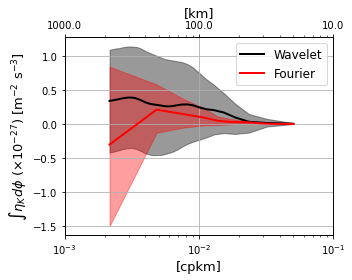

In [14]:
for reg in range(len(xs)-5):
    
    ds = xr.open_dataset(op.join(savedir,'AdvSnapPVTrans_region%02d_1967-01-01.zarr' % reg))
    dks = xr.DataArray(np.abs(np.diff(ds.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds.scale[1:].data + ds.scale[:-1].data)}
                      ).interp(scale=ds.scale, kwargs={"fill_value": "extrapolate"})
    # eta = ((ds.App + ds.Au + ds.Aw + ds.MtE)
    #        * dks).cumsum('scale').compute()
    eta = ((ds.App + ds.MtE) * dks).isel(Z=1).cumsum('scale').sum('angle').compute() * np.diff(ds.angle)[0]*2
    datas = (eta, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Ewres = bootstrap(datas, np.mean, confidence_level=0.95,
                      random_state=rng)

    dsf = xr.open_dataset(op.join(savedir,'FourierAdvSnapPVTrans_region%02d_1967-01-01.zarr' % reg))
    # iso_cs = xrft.isotropize((dsf.App + dsf.Au + dsf.Aw + dsf.MtE).mean(['nmemb']).real, 
    #                          ["freq_YC","freq_XC"], truncate=True).compute()
    iso_cs = xrft.isotropize((dsf.App + dsf.MtE).real, 
                             ["freq_YC","freq_XC"], truncate=True
                            )
    etaf = (iso_cs * np.abs(np.diff(iso_cs.freq_r)[0])
           ).isel(Z=1)[...,::-1].cumsum('freq_r')[...,::-1].compute() * 2*np.pi
    datas = (etaf, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Efres = bootstrap(datas, np.mean, confidence_level=0.95,
                      random_state=rng)

    fig, ax = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
#             ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between((eta.scale)**-1*1e3, Ewres.confidence_interval.low*1e27, Ewres.confidence_interval.high*1e27, 
                    alpha=.4, color='k')
    ax.fill_between(etaf.freq_r*1e3, Efres.confidence_interval.low*1e27, Efres.confidence_interval.high*1e27, 
                    alpha=.38, color='r')
    
    # ax.plot((eta.scale)**-1*1e3, eta.isel(angle=0,Z=0).mean(['nmemb'])*1e26,
    #                 'r', lw=2, label=r"Zonal")
    # ax.plot((eta.scale)**-1*1e3, eta.isel(angle=len(eta.angle)//2,Z=0).mean(['nmemb'])*1e26,
    #                 'c', lw=2, label=r"Meridional")
    # ax.plot((eta.scale)**-1*1e3, eta.isel(Z=0).mean(['nmemb','angle'])*1e26,
    #                 'k', lw=2, label=r"Isotropic")
    ax.plot((eta.scale)**-1*1e3, eta.mean(['nmemb'])*1e27,
            'k', lw=2, label=r"Wavelet")
    ax.plot((etaf.freq_r)*1e3, etaf.mean(['nmemb'])*1e27,
            'r', lw=2, label=r"Fourier")
    ax.set_xscale('log')
#             ax.set_yscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    # ax.set_ylim([-5e-3,None])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"$\int\eta_K d\phi$ ($\times 10^{-27}$) [m$^{-2}$ s$^{-3}$]", fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^{-2}$ s$^{-3}$]", fontsize=13)
    ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
    if reg == 0:
        ax.legend(loc='upper right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(savedir,'Figs/WvsF-Ens-specflux_Region%02d_Z452.pdf' % reg))
    # plt.savefig(op.join(savedir,'Figs/WvsF-Ens-specflux_reenvisioned_Region%02d_Z452.pdf' % reg))
    plt.show()

In [15]:
reg = 0
ds = xr.open_dataset(op.join(savedir,'AdvSnapPVTrans_region%02d_1967-01-01.zarr' % reg))
ds

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:  (nmemb: 48, Z: 3, angle: 18, scale: 40)
Coordinates:
  * Z        (Z) float32 -227.6 -452.4 -1.137e+03
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 1.983e+04 3.118e+04 ... 4.511e+05 4.624e+05
Data variables:
    App      (nmemb, Z, angle, scale) float64 ...
    MtE      (Z, angle, scale, nmemb) float64 ...

In [16]:
dks = xr.DataArray(np.abs(np.diff(ds.scale**-1)).data, dims='scale',
                   coords={'scale':.5*(ds.scale[1:].data + ds.scale[:-1].data)}
                  ).interp(scale=ds.scale, kwargs={"fill_value": "extrapolate"})
# eta = ((ds.App + ds.Au + ds.Aw + ds.MtE)
#        * dks).cumsum('scale').compute()
eta = ((ds.App) * dks).cumsum('scale').compute()
eta

<xarray.DataArray (nmemb: 48, Z: 3, angle: 18, scale: 40)>
array([[[[ 6.24295756e-31,  7.13788497e-30,  5.01722652e-29, ...,
          -7.06922924e-27, -7.13135602e-27, -7.18449367e-27],
         [-6.70823850e-31,  3.37658025e-30,  1.07907497e-29, ...,
          -7.00188872e-27, -7.00610930e-27, -7.00593463e-27],
         [-1.39462578e-30,  2.27559003e-30,  1.04981309e-29, ...,
          -2.38197349e-27, -2.34061746e-27, -2.30605862e-27],
         ...,
         [ 4.52752635e-30,  6.17942637e-28,  6.97725411e-27, ...,
           4.41751580e-26,  4.42449153e-26,  4.42997073e-26],
         [ 2.07902999e-30,  2.32509476e-28,  2.15349522e-27, ...,
           2.10083924e-26,  2.10156779e-26,  2.10157607e-26],
         [ 2.12486485e-30,  7.88968697e-29,  3.85419626e-28, ...,
           5.79248603e-27,  5.74152630e-27,  5.69282570e-27]],

        [[-1.09202273e-32, -7.36329018e-34, -7.11242282e-32, ...,
          -3.42072670e-28, -3.44077380e-28, -3.45177475e-28],
         [ 1.59073854e-32,  2.77754564e-32, -1.42923217e-31, ...,
           1.56275289e-28,  1.56384210e-28,  1.57191777e-28],
         [ 8.08633699e-33,  4.91705808e-32, -5.38372166e-31, ...,
           2.02253814e-28,  2.03086708e-28,  2.04246267e-28],
...
         [-1.27811460e-31, -2.66089232e-30, -4.93147640e-30, ...,
          -1.59968624e-28, -1.52360950e-28, -1.45696993e-28],
         [-2.87053159e-32, -2.97745515e-31, -1.92403452e-31, ...,
           1.14885072e-29,  1.51823939e-29,  1.85930831e-29],
         [ 3.79033216e-32,  1.18292303e-31,  4.65711176e-31, ...,
          -8.02064028e-29, -8.08241385e-29, -8.11760752e-29]],

        [[-5.37395451e-35,  2.07004673e-34,  1.75514764e-32, ...,
          -9.46210120e-30, -9.57340963e-30, -9.66983595e-30],
         [-9.60834686e-36,  1.94503282e-33,  1.78268630e-32, ...,
          -3.62584271e-30, -3.67846771e-30, -3.72137916e-30],
         [ 3.11468807e-34,  7.84890707e-33,  3.88890948e-33, ...,
           8.69536006e-30,  8.70903510e-30,  8.71133544e-30],
         ...,
         [ 1.91784424e-35, -2.26616800e-33, -6.46560314e-33, ...,
          -6.26657199e-30, -6.29001820e-30, -6.31779111e-30],
         [ 4.64249862e-35, -1.56916505e-33,  1.02300474e-32, ...,
          -6.83625414e-31, -8.00588355e-31, -9.16892082e-31],
         [ 1.15533228e-34, -5.01040272e-34,  1.65538807e-32, ...,
          -5.32483471e-30, -5.47698596e-30, -5.62050783e-30]]]])
Coordinates:
  * Z        (Z) float32 -227.6 -452.4 -1.137e+03
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 1.983e+04 3.118e+04 ... 4.511e+05 4.624e+05

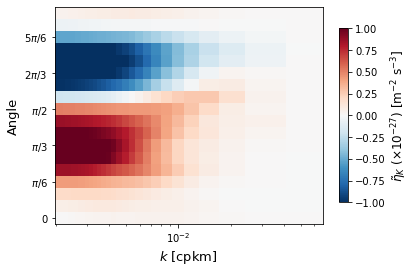

In [31]:
fig, ax = plt.subplots()
im = ax.pcolormesh((eta.scale)**-1*1e3, eta.angle, eta.isel(Z=1).mean('nmemb')*1e27,
                   vmax=1., vmin=-1.,
                   cmap='RdBu_r', rasterized=True
                  )
ax.set_xscale('log')
ax.set_xlabel(r"$k$ [cpkm]", fontsize=13)
ax.set_ylabel(r"Angle", fontsize=13)
ax.set_yticks([eta.angle[0], eta.angle[3], eta.angle[6], eta.angle[9], eta.angle[12], eta.angle[15]])
ax.set_yticklabels(['0', r"$\pi/6$", r"$\pi/3$", r"$\pi/2$", r"$2\pi/3$", r"$5\pi/6$"])
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"$\tilde{\eta}_K$ ($\times 10^{-27}$) [m$^{-2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figs/Ens-specflux_Region%02d_phi-K_Z452.pdf' % reg))
# plt.savefig(op.join(savedir,'Figs/Ens-specflux_reenvisioned_Region%02d_phi-K_Z452.pdf' % reg))

In [17]:
dskl = xr.open_zarr(op.join(savedir,'K-L/1967-01-01.zarr'))

a = np.sqrt(dskl.K + dskl.L)
b = np.sqrt(dskl.K - dskl.L)

a25 = np.sqrt(dskl.K_250km + dskl.L_250km)
b25 = np.sqrt(dskl.K_250km - dskl.L_250km)


ratio = a/b
ratio25 = a25/b25


xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

In [18]:
angles = np.linspace(-np.pi,np.pi,40)
dg = 32
xx = xr.DataArray(np.ones((2, len(angles), len(xs))),
                  dims=['ab','angle','reg'],
                  coords={'angle':angles,'reg':range(6)}
                 ) * np.nan
xx25 = xx.copy()


for i in range(len(xs)):
    # rotation = np.matrix([
    #                   [ np.cos(dskl.theta.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')), 
    #                    -np.sin(dskl.theta.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))], 
    #                   [ np.sin(dskl.theta.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')),  
    #                     np.cos(dskl.theta.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))]]
    #                )
    axes = np.array([a.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.cos(angles),
                     b.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.sin(angles)]
               )
    # xx.isel(reg=i)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
    xx.isel(reg=i)[:] = axes
    
    # rotation = np.matrix([
    #                   [ np.cos(dskl25.theta_250km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')), 
    #                    -np.sin(dskl25.theta_250km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))], 
    #                   [ np.sin(dskl25.theta_250km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')),  
    #                     np.cos(dskl25.theta_250km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))]]
    #                )
    axes = np.array([a25.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.cos(angles),
                     b25.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.sin(angles)]
               )
    # xx25.isel(reg=i)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
    xx25.isel(reg=i)[:] = axes

In [19]:
r = a*b / np.sqrt((b*xr.DataArray(np.cos(angles),dims='angle',coords={'angle':angles}))**2 
                  + (a*xr.DataArray(np.sin(angles),dims='angle',coords={'angle':angles}))**2)
r25 = a25*b25 / np.sqrt((b25*xr.DataArray(np.cos(angles),dims='angle',coords={'angle':angles}))**2 
                        + (a25*xr.DataArray(np.sin(angles),dims='angle',coords={'angle':angles}))**2)

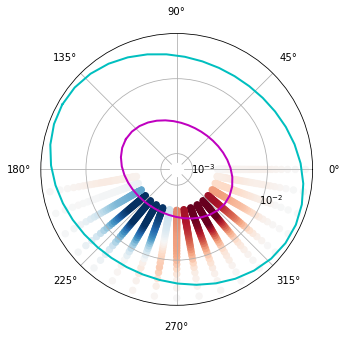

In [20]:
def polar_twin(ax):
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                             label='twin', frameon=False,
                             theta_direction=ax.get_theta_direction(),
                             theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)
    # # There should be a method for this, but there isn't... Pull request?
    # ax2._r_label_position._t = (22.5 + 180, 0.0)
    # ax2._r_label_position.invalidate()
    # # Ensure that original axes tick labels are on top of plots in twinned axes
    # for label in ax.get_yticklabels():
    #     ax.figure.texts.append(label)
    return ax2

reg = 0

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='polar')
ax2 = polar_twin(ax)
for i in range(len(eta.angle)):
    # y = piw.scale**-1*1e3 * np.sin(piw.angle.isel(angle=i))
    # x = piw.scale**-1*1e3 * np.cos(piw.angle.isel(angle=i))
    # ax.scatter(x, y, c=piw.isel(Z=1,angle=i).mean('nmemb')*1e8, 
    #            cmap='RdBu_r', vmax=.008, vmin=-.008, s=20)
    im = ax.scatter(-eta.angle.isel(angle=i).values*np.ones_like(eta.scale), eta.scale**-1*1e3,
                    c=eta.isel(Z=1,angle=i).mean('nmemb')*1e27, 
                    cmap='RdBu_r', vmax=1., vmin=-1., s=40)

# ax.plot(xx.isel(reg=0)[0]/a.isel(Z=0).sel(XC=xs[0], YC=ys[0], method='nearest'), 
#         xx.isel(reg=0)[1]/a.isel(Z=0).sel(XC=xs[0], YC=ys[0], method='nearest'), 
#         'k', alpha=.7)

ax2.plot(angles+dskl.theta.isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values, 
         (r/a).isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values*eta.scale[0].values**-1*1e3, 
         'c', lw=2)
ax2.plot(angles+dskl.theta_250km.isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values, 
         (r25/a25).isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values*eta.scale[0].values**-1*1e3*.45, 
         'm', lw=2)

ax.set_rticks([1e-3, 1e-2]) 
ax.set_rlabel_position(-24.5) 
ax.set_rlim(9e-4, eta.scale[0]**-1*1e3)
ax.set_rscale('symlog', linthresh=1e-3)
ax.grid(True)
ax2.grid(False)
ax2.set_yticklabels([])
# cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\tilde{\epsilon}_K$ ($\times 10^{-8}$) [m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figs/Polar_Ensflux_region%02d_Z452.pdf' % reg))
# plt.savefig(op.join(savedir,'Figs/Polar_Ensflux_reenvisioned_region%02d_Z452.pdf' % reg))